In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Loading dataset for mnist
mnist_ds = torchvision.datasets.MNIST("./data",download=True,train=True,transform=torchvision.transforms.ToTensor())
dl = torch.utils.data.DataLoader(mnist_ds,batch_size=128)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# Specifying the device to be used: CPU or GPU
dev = torch.device("cuda:0")
#dev = torch.device("cpu")

GAN using Linear Layers

In [ ]:
# Defining the models: generator and discriminator
model_discriminator = nn.Sequential(
    nn.Linear(784,256),
    nn.LeakyReLU(0.2,inplace=True),
    nn.Linear(256,256),
    nn.LeakyReLU(0.2,inplace=True),
    nn.Linear(256,1),
    nn.Sigmoid()
).to(dev)

model_generator = nn.Sequential(
    nn.Linear(64,256),
    nn.ReLU(inplace=True),
    nn.Linear(256,256),
    nn.ReLU(inplace=True),
    nn.Linear(256,784),
    nn.Tanh()
).to(dev)

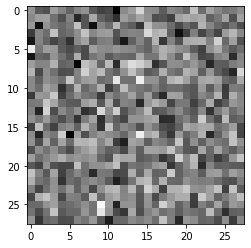

In [ ]:
# Testing the generator model
x = torch.rand((1,64)).to(dev)
imgs = model_generator(x)[0].cpu().detach().numpy()
plt.imshow(imgs.reshape(28,28),cmap="gray")

In [ ]:
# Defining the binary cross entropy loss function and the optimizers for each model
crit = nn.BCELoss()
disc_optim = torch.optim.Adam(model_discriminator.parameters(),lr=0.0002)
gen_optim = torch.optim.Adam(model_generator.parameters(),lr=0.0002)

In [ ]:
# Defining the training functions for each model
def train_discriminator(imgs):
  disc_optim.zero_grad()
  gen_optim.zero_grad()
  
  disc_o = model_discriminator(imgs)
  bs,_ = disc_o.shape
  real_labels = torch.ones((bs,1)).to(dev)
  fake_labels = torch.zeros((bs,1)).to(dev)
  disc_loss = crit(disc_o,real_labels)

  noise = torch.randn(bs,64).to(dev)
  fake_imgs = model_generator(noise)
  disc_fake = model_discriminator(fake_imgs)
  gen_loss = crit(disc_fake,fake_labels)

  loss = disc_loss + gen_loss

  loss.backward()

  disc_optim.step()

  return loss, disc_o, disc_fake, bs

def train_generator(bs):
  disc_optim.zero_grad()
  gen_optim.zero_grad()
  
  noise = torch.randn(bs,64).to(dev)
  fake_imgs = model_generator(noise)
  labels = torch.ones(bs,1).to(dev)
  gen_loss = crit(model_discriminator(fake_imgs),labels) 

  gen_loss.backward()
  gen_optim.step()

  return gen_loss, fake_imgs

In [ ]:
# Training 
EPOCHS=200
disc_losses = []
gen_losses = []
fake_imgs_hist = []
for epoch in range(EPOCHS):
  print(f"epoch: {epoch}")
  for k,(x,_) in enumerate(dl):
    imgs = x.view((-1,784)).to(dev)

    disc_loss, disc_o, disc_fake, bs = train_discriminator(imgs)
    gen_loss, fake_imgs = train_generator(bs)

    if (k+1)%200 == 0:
      disc_losses.append(disc_loss)
      gen_losses.append(gen_loss)
      fake_imgs_hist.append(fake_imgs)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100

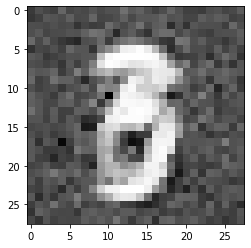

In [ ]:
# Generating some fake images with the trained generator model
x = torch.randn((10,64)).to(dev)
imgs = model_generator(x)[0].cpu().detach().numpy()
plt.imshow(imgs.reshape(28,28),cmap="gray")

In [ ]:
torch.save(model_generator,"model_generator")

GAN using Convolutional Layers

In [8]:
# Creating the reshape module (for reshaping tensors within a sequential mode)
class Reshape(nn.Module):
  def __init__(self,new_shape):
    super().__init__()
    self.new_shape = new_shape
  
  def forward(self,x):
    return x.view(self.new_shape)

In [9]:
model_discriminator = nn.Sequential(
    nn.Conv2d(1,8,4,stride=2,bias=False),
    nn.LeakyReLU(inplace=True),
    nn.Conv2d(8,16,3,stride=2,bias=False),
    nn.LeakyReLU(inplace=True),
    Reshape((-1,576)),
    nn.Linear(576,64,bias=False),
    nn.LeakyReLU(inplace=True),
    nn.Linear(64,1,bias=False),
    nn.Sigmoid()
).to(dev)

model_generator = nn.Sequential(
    nn.Linear(64,576,bias=False),
    nn.ReLU(inplace=True),
    Reshape((-1,16,6,6)),
    nn.ConvTranspose2d(16,8,3,stride=2,bias=False),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(8,1,4,stride=2,bias=False),
    nn.Tanh()
).to(dev)

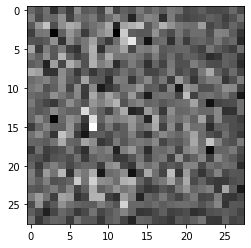

In [14]:
# Testing the models
x = torch.rand((1,64)).to(dev)
img = model_generator(x).cpu().detach().numpy()[0][0]
plt.imshow(img,cmap="gray")

# x = torch.rand((1,1,28,28)).to(dev)
# print(model_discriminator(x))

In [15]:
crit = nn.BCELoss()
disc_optim = torch.optim.Adam(model_discriminator.parameters(),lr=0.0004)
gen_optim = torch.optim.Adam(model_generator.parameters(),lr=0.0004)

In [22]:
def train_discriminator(imgs):
  disc_optim.zero_grad()
  gen_optim.zero_grad()

  N = imgs.shape[0]

  disc_o = model_discriminator(imgs)
  real_labels = torch.ones_like(disc_o).to(dev)
  fake_labels = torch.zeros_like(disc_o).to(dev)

  disc_loss = crit(disc_o,real_labels)

  noise = torch.randn((N,64)).to(dev)
  fake_imgs = model_generator(noise)
  gen_o = model_discriminator(fake_imgs)
  gen_loss = crit(gen_o,fake_labels)

  tot_loss = disc_loss + gen_loss
  
  tot_loss.backward()
  disc_optim.step()

  return N,tot_loss

def train_generator(N):
  disc_optim.zero_grad()
  gen_optim.zero_grad()

  noise = torch.randn((N,64)).to(dev)
  fake_imgs = model_generator(noise)
  gen_o = model_discriminator(fake_imgs)
  labels = torch.ones((N,1)).to(dev)
  gen_loss = crit(gen_o,labels)

  gen_loss.backward()
  gen_optim.step()

  return fake_imgs, gen_loss

In [23]:
EPOCHS = 50
disc_loss_arr = []
gen_loss_arr = []
fake_imgs_arr= []

for epoch in range(EPOCHS):
  for k,(x,_) in enumerate(dl):
    x = x.to(dev)
    N,disc_loss = train_discriminator(x)
    fake_imgs, gen_loss = train_generator(N)

    if (k%200) == 0:
      fake_imgs_arr.append(fake_imgs)
      disc_loss_arr.append(disc_loss)
      gen_loss_arr.append(gen_loss)
  print(f"epoch: {epoch}")

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49


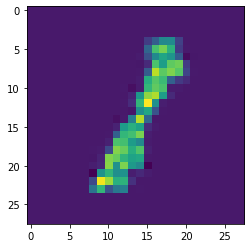

In [36]:
plt.imshow(fake_imgs_arr[-1].cpu().detach().numpy()[16][0])

In [41]:
!mkdir gan_fake_imgs

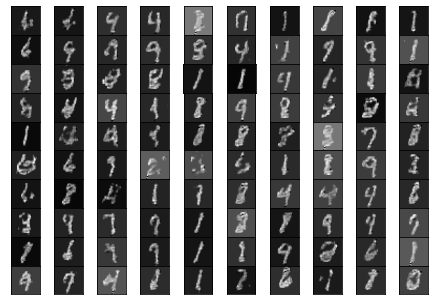

In [92]:
sub_imgs_arr = fake_imgs_arr[101].cpu().detach().numpy()
fig, axs = plt.subplots(nrows=10,ncols=10)
for k in range(100):
  axs[k//10,k%10].imshow(sub_imgs_arr[k][0],cmap='gray')
  axs[k//10,k%10].axes.xaxis.set_visible(False)
  axs[k//10,k%10].axes.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
# plt.savefig(f"gan_fake_imgs/fake_img{idx}.png")

In [ ]:
for idx in range(150):
  sub_imgs_arr = fake_imgs_arr[idx].cpu().detach().numpy()
  fig, axs = plt.subplots(nrows=10,ncols=10)
  for k in range(100):
    axs[k//10,k%10].imshow(sub_imgs_arr[k][0],cmap='gray')
    axs[k//10,k%10].axes.xaxis.set_visible(False)
    axs[k//10,k%10].axes.yaxis.set_visible(False)
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  plt.savefig(f"gan_fake_imgs/fake_img{idx}.png")

In [49]:
!tar -czf gan_fake_imgs.tar.gz gan_fake_imgs/

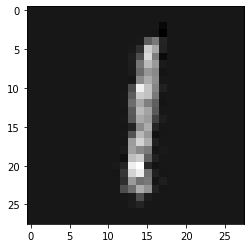

In [91]:
x = torch.randn((1,64)).to(dev)
img = model_generator(x).cpu().detach().numpy()[0][0]
plt.imshow(img,cmap="gray")